In [1]:
from google.cloud import bigquery as bq
import numpy as np
import pandas as pd
import warnings
import statsmodels.stats.api as sms
warnings.filterwarnings("ignore", category=UserWarning)
c = bq.Client.from_service_account_json("denizerendeg505.json")



def ab_result(a, b, alpha = 0.05, test = 'z', plot = True, aa_test = True):
    from scipy import stats
    import matplotlib.pyplot as plt
    if aa_test:
        sample1_a = a.sample(n=round(a.shape[0]*0.45), random_state=17)
        sample2_a = a.drop(sample1_a.index).sample(n=round(a.shape[0]*0.45), random_state=19)
        sample1_b = b.sample(n=round(b.shape[0]*0.45), random_state=17)
        sample2_b = b.drop(sample1_b.index).sample(n=round(b.shape[0]*0.45), random_state=19)
        _, pvalue = stats.mannwhitneyu(sample1_a.astype(float), sample2_a.astype(float))
        if pvalue <= alpha:
            print(f'A/A Test failed for group A.')
            return
        _, pvalue = stats.mannwhitneyu(sample1_b.astype(float), sample2_b.astype(float))
        if pvalue <= alpha:
            print(f'A/A Test failed for group B.')
            return                              
        print("A/A Test passed successfully!")

    group_A = list(a)
    group_B = list(b)    
    z_crit = stats.norm.ppf(1- alpha/2)
    if test == 'z':
       print(f'{test} test is being used...')
       n_A = len(group_A)
       n_B = len(group_B)
       
       # Means and stds
       mean_A = np.mean(group_A)
       mean_B = np.mean(group_B)
       std_A = np.std(group_A, ddof=1)
       std_B = np.std(group_B, ddof=1)
       
       # Z stat
       pooled_std = np.sqrt((std_A**2 / n_A) + (std_B**2 / n_B))
       test_stat = (mean_A - mean_B) / pooled_std

        # p value
       p_value = 2 * stats.norm.sf(abs(test_stat))
       print("H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)")
       print("H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)")
       if p_value <= alpha:
           print(f"p-value({p_value})  <=  alpha({alpha})")
           print(f'The null hypothesis(H0) is rejected at a significance level of {alpha}')
       else:
           print(f"p-value({p_value})  >  alpha({alpha})")
           print(f'The null hypothesis(H0) CANNOT be rejected at a significance level of {alpha}')
    elif test == 't':
        print(f'{test} test is being used...')
        test_stat, p_value = stats.ttest_ind(group_A, group_B)
        print("H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)")
        print("H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)")
        if p_value <= alpha:
            print(f"p-value({p_value})  <=  alpha({alpha})")
            print(f'The null hypothesis(H0) is rejected at a significance level of {alpha}')
        else:
            print(f"p-value({p_value})  >  alpha({alpha})")
            print(f'The null hypothesis(H0) CANNOT be rejected at a significance level of {alpha}')
    else:
        print(f"{test} test is not defined!")
        return
        
    if plot == True:
       mu = 0
       sigma = 1
       x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
       y = stats.norm.pdf(x, mu, sigma)
       plt.plot(x, y, label = 'Standard Normal Distribution')
       plt.fill_between(x, y, where = (x>z_crit) | (x<-z_crit), color='red', alpha=0.9, label='Rejection Region')
       plt.axvline(test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Stat {test_stat:.2f}')
       plt.axvline(z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-Critical {z_crit:.2f}')
       plt.axvline(-z_crit, color='blue', linestyle='dashed', linewidth=1)
       plt.xlabel('Z-value')
       plt.ylabel('Probability Density')
       plt.title('Gaussian Normal Distribution')
       plt.legend()
       plt.show() 

In [2]:
query = """ 

SELECT *
FROM casedreamgames.case_db.q2_table_ab_test_enter

"""
df = c.query(query).to_dataframe()
df

,test_entry_timestamp,install_timestamp,user_id,group_id,platform
0,2022-02-10 21:18:32.458000+00:00,2022-02-10 21:18:34+00:00,txlqw6185177497a2,A,ios
1,2022-02-15 14:40:10.184000+00:00,2022-02-15 14:40:20+00:00,txlqw6185791752a2,A,ios
2,2022-02-28 19:14:31.079000+00:00,2022-02-28 19:14:31+00:00,txlqw6187363919a2,A,ios
3,2022-02-25 01:51:13.344000+00:00,2022-02-25 01:54:09+00:00,txlqw6186918784a2,A,ios
4,2022-02-20 15:07:52.962000+00:00,2022-02-20 15:07:56+00:00,txlqw6186405215a2,A,ios
...,...,...,...,...,...
73445,2022-02-13 08:12:32.602000+00:00,NaT,txlqw6185500868a2,B,ios
73446,2022-02-26 16:39:02.368000+00:00,NaT,txlqw6187103070a2,B,ios
73447,2022-02-14 15:12:46.728000+00:00,NaT,txlqw6185674719a2,B,ios
73448,2022-02-28 10:23:30.656000+00:00,NaT,txlqw6187314123a2,B,android


In [3]:
df.groupby("group_id").agg({"install_timestamp": "count"})

,install_timestamp
group_id,
A,36569
B,35680


In [26]:
query = """ 

SELECT
    s.user_id,
    SUM(s.time_spent) AS total_timespent,
    MAX(s.level) as level,
    COUNT(event_timestamp) AS session_count,
    SUM(s.time_spent) / COUNT(event_timestamp) AS timespent_per_session,
    e.group_id
FROM
    casedreamgames.case_db.q2_table_ab_test_session s
LEFT JOIN
    casedreamgames.case_db.q2_table_ab_test_enter e
ON
    s.user_id = e.user_id
GROUP BY
    s.user_id,
    e.group_id;


"""
df = c.query(query).to_dataframe()
df

,user_id,total_timespent,level,session_count,timespent_per_session,group_id
0,txlqw6184683219a2,491940,1274,16785,29.308311,A
1,txlqw6184686342a2,9183,72,316,29.060127,A
2,txlqw6184688003a2,539788,1864,18331,29.446730,A
3,txlqw6184695504a2,224417,449,7897,28.418007,A
4,txlqw6184701158a2,484604,1107,16571,29.244101,A
...,...,...,...,...,...,...
73194,txlqw6186356683a2,6,1,1,6.000000,B
73195,txlqw6187725653a2,7,1,1,7.000000,B
73196,txlqw6187296343a2,4,1,1,4.000000,B
73197,txlqw6185274051a2,3,1,1,3.000000,B


In [27]:
df.groupby("group_id").agg({"total_timespent": "mean", 
                            "level": "mean",
                            "session_count":"mean",
                            "timespent_per_session": "mean"})

,total_timespent,level,session_count,timespent_per_session
group_id,,,,
A,99964.885562,283.489441,3456.950427,26.979050
B,76356.688666,154.439732,2656.855877,26.926241


# 1) Time Spent

Confidence Interval:
(87286.65934431854, 89342.92220734201)
A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(1.4705639822420505e-113)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


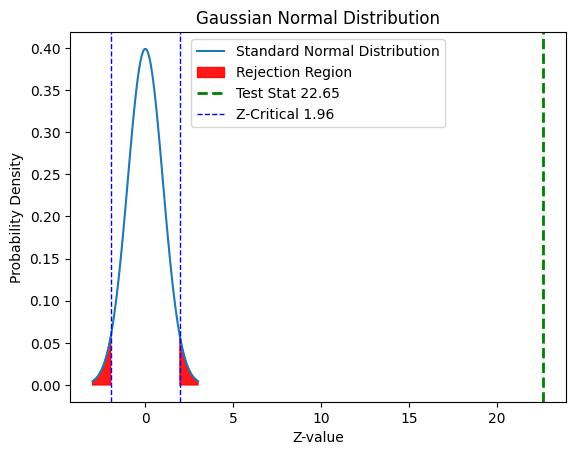

In [19]:
print('Confidence Interval:')
print(sms.DescrStatsW(df["total_timespent"]).tconfint_mean(alpha=0.05, alternative='two-sided'))
A = df[df["group_id"] == "A"]["total_timespent"]
B = df[df["group_id"] == "B"]["total_timespent"]
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grubun oyunda gecirdigi toplam zaman %95 ihtimalle daha az.

# 2) Session Count

Confidence Interval:
(3026.5655868391946, 3097.6792525711803)
A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(4.4501436892908715e-109)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


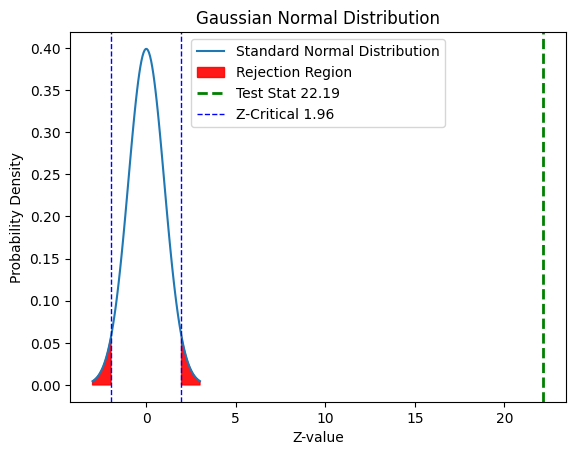

In [20]:
print('Confidence Interval:')
print(sms.DescrStatsW(df["session_count"]).tconfint_mean(alpha=0.05, alternative='two-sided'))
A = df[df["group_id"] == "A"]["session_count"]
B = df[df["group_id"] == "B"]["session_count"]
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grubun oyuna giris sayisi %95 ihtimalle daha az.

# 3) Time Spent per Session

Confidence Interval:
(26.916332161282785, 26.989647583920753)
A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(0.15787022164233722)  >  alpha(0.05)
The null hypothesis(H0) CANNOT be rejected at a significance level of 0.05


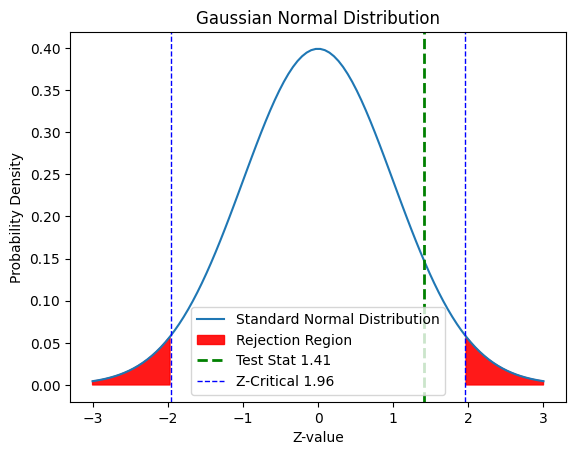

In [21]:
print('Confidence Interval:')
print(sms.DescrStatsW(df["timespent_per_session"]).tconfint_mean(alpha=0.05, alternative='two-sided'))
A = df[df["group_id"] == "A"]["timespent_per_session"]
B = df[df["group_id"] == "B"]["timespent_per_session"]
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grup ile control(A) grubunun time spent per session degilimlari %95 ihtimalle ayni. 

# 4) Level

Confidence Interval:
(217.4909787629578, 222.12185747797446)
A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(0.0)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


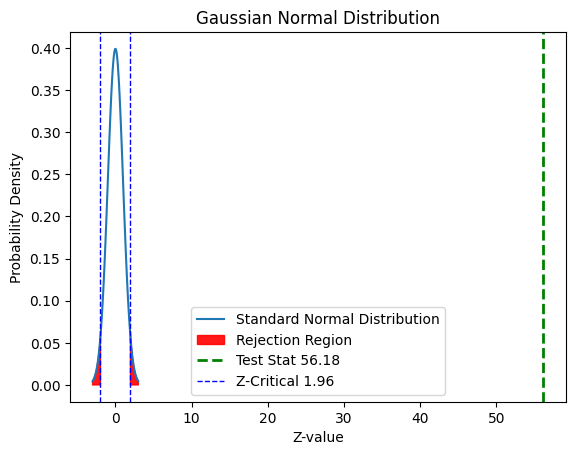

In [23]:
print('Confidence Interval:')
print(sms.DescrStatsW(df["level"]).tconfint_mean(alpha=0.05, alternative='two-sided'))
A = df[df["group_id"] == "A"]["level"]
B = df[df["group_id"] == "B"]["level"]
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grubunun level seviyesi %95 ihtimalle daha dusuk.

In [28]:
query = """ 

SELECT
    r.user_id,
    MAX(r.level) as level,
    SUM(r.dollar_amount) AS total_payment, 
    COUNT(event_timestamp) AS transaction_count,
    SUM(r.dollar_amount) / COUNT(event_timestamp) AS average_order_value,
    e.group_id
FROM
    casedreamgames.case_db.q2_table_ab_test_revenue r
LEFT JOIN
    casedreamgames.case_db.q2_table_ab_test_enter e
ON
    r.user_id = e.user_id
GROUP BY
    r.user_id,
    e.group_id;


"""
df = c.query(query).to_dataframe()
df['purchase_freq'] = df['transaction_count'] / df.shape[0]
df

,user_id,level,total_payment,transaction_count,average_order_value,group_id,purchase_freq
0,txlqw6184698563a2,414,12.0,4,3.000000,B,0.000662
1,txlqw6184776261a2,847,6.0,3,2.000000,A,0.000496
2,txlqw6184783806a2,1439,31.0,5,6.200000,A,0.000827
3,txlqw6184814200a2,427,29.0,7,4.142857,B,0.001158
4,txlqw6184952625a2,618,8.0,3,2.666667,B,0.000496
...,...,...,...,...,...,...,...
6038,txlqw6185846734a2,18,17.0,1,17.000000,A,0.000165
6039,txlqw6186336912a2,45,32.0,1,32.000000,B,0.000165
6040,txlqw6187494221a2,25,17.0,1,17.000000,A,0.000165
6041,txlqw6185136350a2,213,4.0,1,4.000000,B,0.000165


In [29]:
df.groupby("group_id")[['total_payment', 'transaction_count', 'average_order_value', 'purchase_freq']].mean()

,total_payment,transaction_count,average_order_value,purchase_freq
group_id,,,,
A,158.042056,11.466211,9.725217,0.001897
B,169.554125,13.195339,9.146076,0.002184


# 5) Total Payment

Confidence Interval:
(151.26316449660504, 177.24552324127347)
A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(0.3739798636573419)  >  alpha(0.05)
The null hypothesis(H0) CANNOT be rejected at a significance level of 0.05


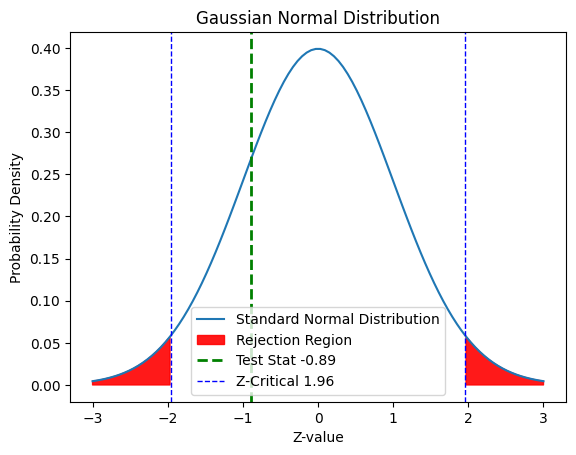

In [30]:
print('Confidence Interval:')
print(sms.DescrStatsW(df["total_payment"]).tconfint_mean(alpha=0.05, alternative='two-sided'))
A = df[df["group_id"] == "A"]["total_payment"]
B = df[df["group_id"] == "B"]["total_payment"]
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) ve Control(A) gruplarinin yaptiklari total payment dagilimlari %95 ayni.

# 6) Transaction Count

Confidence Interval:
(11.780298621300446, 13.018311340638988)
A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(0.005128313625524875)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


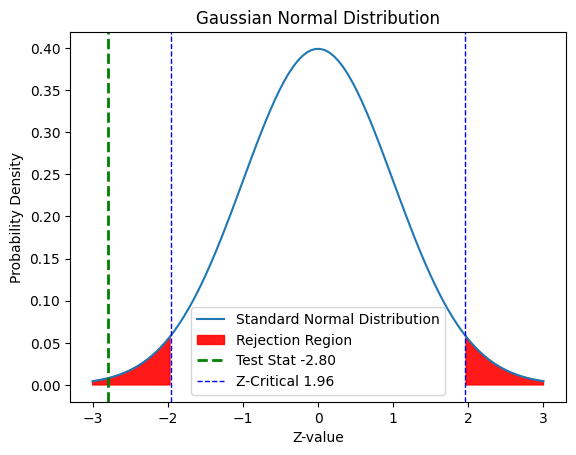

In [31]:
print('Confidence Interval:')
print(sms.DescrStatsW(df["transaction_count"]).tconfint_mean(alpha=0.05, alternative='two-sided'))
A = df[df["group_id"] == "A"]["transaction_count"]
B = df[df["group_id"] == "B"]["transaction_count"]
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) yaptigi transaction sayisi daha fazla.

# 7) AOV

Confidence Interval:
(9.157198037792257, 9.668189604199833)
A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(0.026560784774499985)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


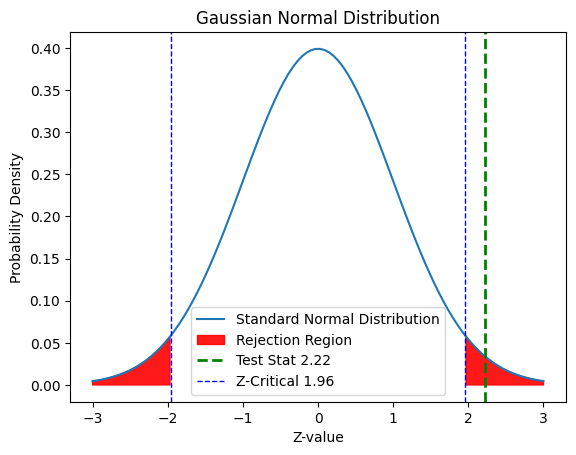

In [32]:
print('Confidence Interval:')
print(sms.DescrStatsW(df["average_order_value"]).tconfint_mean(alpha=0.05, alternative='two-sided'))
A = df[df["group_id"] == "A"]["average_order_value"]
B = df[df["group_id"] == "B"]["average_order_value"]
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grubunun ortalama AOV degeri daha dusuk.

# 8) Purchase Frequency

Confidence Interval:
(0.0019494123152904933, 0.002154279553307786)
A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(0.00512831362552487)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


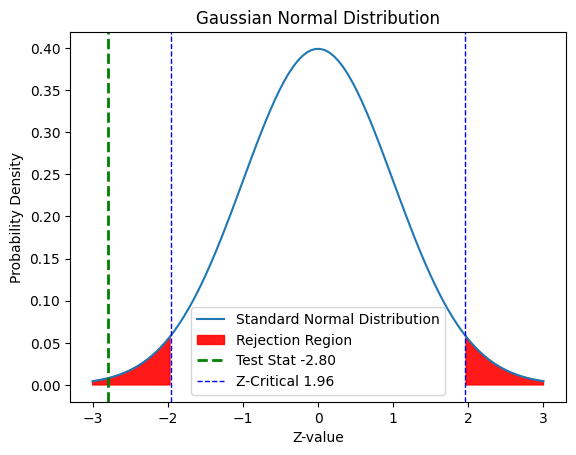

In [33]:
print('Confidence Interval:')
print(sms.DescrStatsW(df["purchase_freq"]).tconfint_mean(alpha=0.05, alternative='two-sided'))
A = df[df["group_id"] == "A"]["purchase_freq"]
B = df[df["group_id"] == "B"]["purchase_freq"]
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grubun purchase frequency degeri daha yuksek.

In [44]:
query = """ 

SELECT
    DATE(s.event_timestamp) AS date,
    e.group_id,
    COUNT(s.user_id) AS session_count
FROM
    casedreamgames.case_db.q2_table_ab_test_session s
LEFT JOIN
    casedreamgames.case_db.q2_table_ab_test_enter e
ON
    s.user_id = e.user_id
GROUP BY
    DATE(s.event_timestamp),
    e.group_id
ORDER BY
    date, e.group_id;


"""
df = c.query(query).to_dataframe()
df = df.pivot_table(index='date', columns='group_id', values='session_count', aggfunc='sum')
df['dau'] = df['A'] + df['B']
df

group_id,A,B,dau
date,,,
2022-02-08,298115,238277,536392
2022-02-09,458676,362938,821614
2022-02-10,568303,460795,1029098
2022-02-11,881210,672234,1553444
2022-02-12,1008822,765885,1774707
...,...,...,...
2022-04-16,1412921,917725,2330646
2022-04-17,1471114,1025475,2496589
2022-04-18,1655212,1243165,2898377


In [47]:
print(f"DAU for group A: {df['A'].mean()}")
print(f"DAU for group B: {df['B'].mean()}")

Avg. DAU for group A: 1780185.4305555555
Avg. DAU for group B: 1332929.8333333333


# 9) DAU

Confidence Interval:
(2892811.4187821317, 3333419.1089956462)
A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(1.563369276418578e-08)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


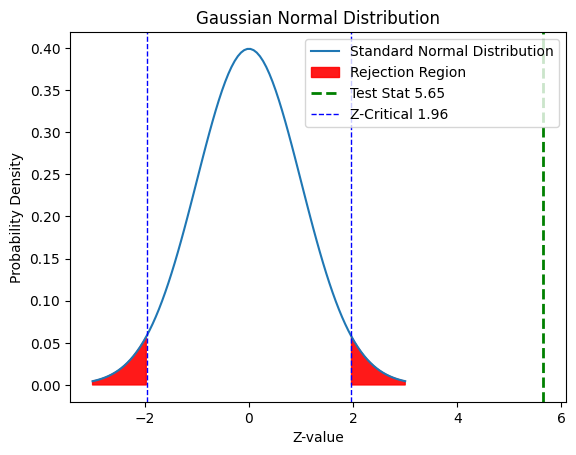

In [48]:
print('Confidence Interval:')
print(sms.DescrStatsW(df['dau']).tconfint_mean(alpha=0.05, alternative='two-sided'))
A = df['A']
B = df['B']
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grubu icin DAU daha dusuk.

In [57]:
query = """ 

WITH daily_revenue AS (
    SELECT
        DATE(r.event_timestamp) AS date,
        e.group_id,
        SUM(r.dollar_amount) AS total_revenue
    FROM
        casedreamgames.case_db.q2_table_ab_test_revenue r
    JOIN
        casedreamgames.case_db.q2_table_ab_test_enter e
    ON
        r.user_id = e.user_id
    GROUP BY
        DATE(r.event_timestamp),
        e.group_id
),

daily_active_users AS (
    SELECT
        DATE(s.event_timestamp) AS date,
        e.group_id,
        COUNT(DISTINCT s.user_id) AS dau
    FROM
        casedreamgames.case_db.q2_table_ab_test_session s
    JOIN
        casedreamgames.case_db.q2_table_ab_test_enter e
    ON
        s.user_id = e.user_id
    GROUP BY
        DATE(s.event_timestamp),
        e.group_id
)

SELECT
    r.date,
    r.group_id,
    r.total_revenue,
    da.dau,
    r.total_revenue / da.dau AS arp_dau
FROM
    daily_revenue r
LEFT JOIN
    daily_active_users da
ON
    r.date = da.date
    AND r.group_id = da.group_id
ORDER BY
    r.date,
    r.group_id;


"""
df = c.query(query).to_dataframe()
df = df.pivot_table(index='date', columns='group_id', values=['total_revenue','dau','arp_dau'], aggfunc='sum')
df

arp_dau              dau       total_revenue        
group_id           A         B      A     B             A       B
date                                                             
2022-02-08  0.101744  0.153578   1720  1719         175.0   264.0
2022-02-09  0.163450  0.445140   2435  2397         398.0  1067.0
2022-02-10  0.314895  0.411913   3236  3173        1019.0  1307.0
2022-02-11  0.585014  0.642608   4164  4018        2436.0  2582.0
2022-02-12  0.662480  0.955192   4936  4709        3270.0  4498.0
...              ...       ...    ...   ...           ...     ...
2022-04-16  0.574120  0.807281  10031  8982        5759.0  7251.0
2022-04-17  0.410418  0.670047  10136  9071        4160.0  6078.0
2022-04-18  0.392097  0.669922   9870  8807        3870.0  5900.0
2022-04-19  0.324499  0.552638   9735  8758        3159.0  4840.0
2022-04-20  0.322531  0.542828   9751  8686        3145.0  4715.0

[72 rows x 6 columns]

# 10) ARPDAU

In [60]:
print(f"ARPDAU for group A: {df['arp_dau']['A'].mean()}")
print(f"ARPDAU for group B: {df['arp_dau']['B'].mean()}")

Avg. ARPDAU for group A: 0.5611780401463016
Avg. ARPDAU for group B: 0.7696417522869932


A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(1.6141170753003553e-13)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


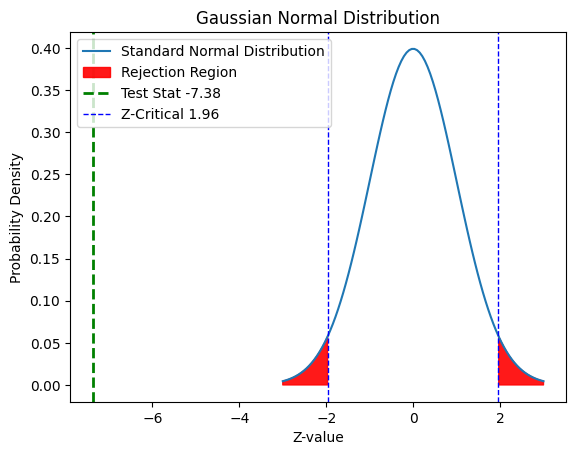

In [62]:
A = df['arp_dau']['A']
B = df['arp_dau']['B']
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grubu icin ARPDAU daha yuksek.

# 11) Daily Total Revenue

In [63]:
print(f"Avg. Daily Revenue for group A: {df['total_revenue']['A'].mean()}")
print(f"Avg. Daily Revenue for group B: {df['total_revenue']['B'].mean()}")

Avg. Daily Revenue for group A: 6106.569444444444
Avg. Daily Revenue for group B: 7679.388888888889


A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(0.0005129920795266452)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


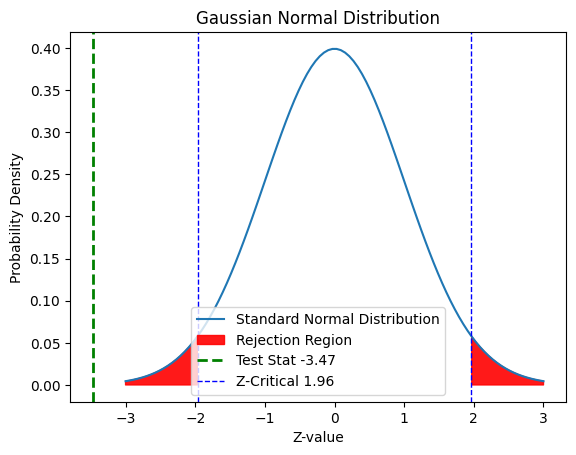

In [64]:
A = df['total_revenue']['A']
B = df['total_revenue']['B']
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grubunun gunluk getirdigi revenue daha yuksek.

In [77]:
query = """ 

WITH daily_revenue AS (
    SELECT
        DATE(r.event_timestamp) AS date,
        e.group_id,
        SUM(r.dollar_amount) AS total_revenue
    FROM
        casedreamgames.case_db.q2_table_ab_test_revenue r
    JOIN
        casedreamgames.case_db.q2_table_ab_test_enter e
    ON
        r.user_id = e.user_id
    GROUP BY
        DATE(r.event_timestamp),
        e.group_id
),

daily_installs AS (
    SELECT
        DATE(e.install_timestamp) AS date,
        e.group_id,
        COUNT(DISTINCT e.user_id) AS total_installs
    FROM
        casedreamgames.case_db.q2_table_ab_test_enter e
    GROUP BY
        DATE(e.install_timestamp),
        e.group_id
)

SELECT
    r.date,
    r.group_id,
    r.total_revenue,
    i.total_installs,
    r.total_revenue / i.total_installs AS arp_install
FROM
    daily_revenue r
LEFT JOIN
    daily_installs i
ON
    r.date = i.date
    AND r.group_id = i.group_id
ORDER BY
    r.date,
    r.group_id;


"""
df = c.query(query).to_dataframe().dropna()
df = df[df['total_installs'] > 4]
df = df.pivot_table(index='date', columns='group_id', values=['total_revenue','total_installs','arp_install'], aggfunc='sum')
df.head()

arp_install           total_installs       total_revenue        
group_id             A         B              A     B             A       B
date                                                                       
2022-02-08    0.136399  0.204334           1283  1292         175.0   264.0
2022-02-09    0.311424  0.845483           1278  1262         398.0  1067.0
2022-02-10    0.742170  0.945731           1373  1382        1019.0  1307.0
2022-02-11    1.534005  1.683181           1588  1534        2436.0  2582.0
2022-02-12    2.081477  2.943717           1571  1528        3270.0  4498.0

In [78]:
print(f"ARPInstall for group A: {df['arp_install']['A'].mean()}")
print(f"ARPInstall for group B: {df['arp_install']['B'].mean()}")

ARPInstall for group A: 4.545315850239649
ARPInstall for group B: 5.995391874738234


# 12) ARPInstall

A/A Test passed successfully!
t test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(0.05229060907018408)  >  alpha(0.05)
The null hypothesis(H0) CANNOT be rejected at a significance level of 0.05


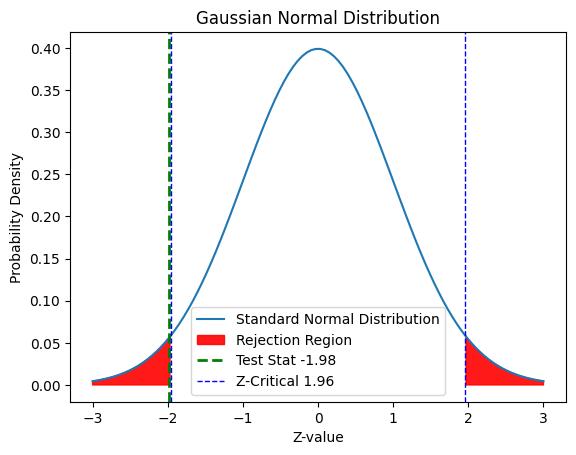

In [80]:
A = df['arp_install']['A']
B = df['arp_install']['B']
ab_result(A, B, test='t', alpha=0.05, aa_test=True)

# Experimental(B) ve control(A) grubunun ARPInstall hemen hemen ayni...
# Eger z testi kullanirsak, H0 rejected oluyor fakat elimizde sadece 28 gunluk
# veri var. Veri azligi sebebiyle (<30) t testi kullanmak daha mantikli.

In [2]:
query = """ 

WITH daily_purchases AS (
    SELECT
        DATE(r.event_timestamp) AS date,
        e.group_id,
        COUNT(DISTINCT r.event_timestamp) AS daily_purchases
    FROM
        casedreamgames.case_db.q2_table_ab_test_revenue r
    JOIN
        casedreamgames.case_db.q2_table_ab_test_enter e
    ON
        r.user_id = e.user_id
    GROUP BY
        DATE(r.event_timestamp),
        e.group_id
),
daily_dau AS (
    SELECT
        DATE(s.event_timestamp) AS date,
        e.group_id,
        COUNT(DISTINCT s.user_id) AS daily_dau
    FROM
        casedreamgames.case_db.q2_table_ab_test_session s
    JOIN
        casedreamgames.case_db.q2_table_ab_test_enter e
    ON
        s.user_id = e.user_id
    GROUP BY
        DATE(s.event_timestamp),
        e.group_id
)
SELECT
    p.date,
    p.group_id,
    p.daily_purchases,
    d.daily_dau,
    (p.daily_purchases / NULLIF(d.daily_dau, 0)) AS trans_per_dau
FROM
    daily_purchases p
JOIN
    daily_dau d
ON
    p.date = d.date
    AND p.group_id = d.group_id
ORDER BY
    p.date,
    p.group_id;


"""
df = c.query(query).to_dataframe()
df = df.pivot_table(index='date', columns='group_id', values='trans_per_dau', aggfunc='sum')
df

group_id,A,B
date,,
2022-02-08,0.014535,0.016870
2022-02-09,0.019302,0.040050
2022-02-10,0.029357,0.038449
2022-02-11,0.044428,0.053509
2022-02-12,0.046191,0.067318
...,...,...
2022-04-16,0.045060,0.066244
2022-04-17,0.040746,0.060412
2022-04-18,0.035360,0.055638


In [3]:
print(f"Number of transactions per DAU for group A: {df['A'].mean()}")
print(f"Number of transactions per DAU for group B: {df['B'].mean()}")

Number of transactions per DAU for group A: 0.041256426068870554
Number of transactions per DAU for group B: 0.06025310984518731


# 13) Number of transactions/DAU

A/A Test passed successfully!
z test is being used...
H0 : M1 = M2  (Control(A) and experimental(B) groups have the same distribution.)
H1 : M1 != M2  (Control(A) and experimental(B) groups DON'T have the same distribution.)
p-value(1.7826052201525774e-33)  <=  alpha(0.05)
The null hypothesis(H0) is rejected at a significance level of 0.05


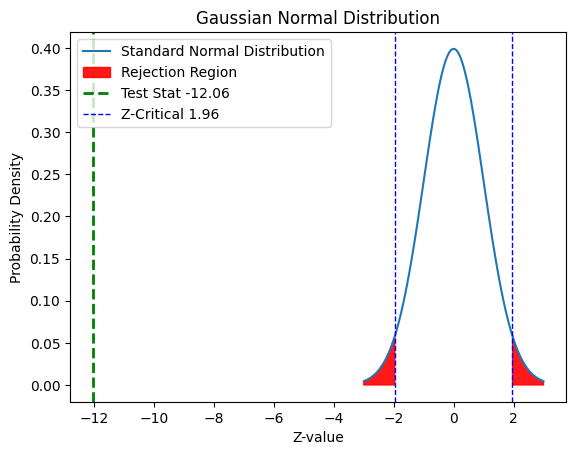

In [87]:
A = df['A']
B = df['B']
ab_result(A, B, test='z', alpha=0.05, aa_test=True)

# Experimental(B) grubunun DAU basina transaction sayisi daha yuksek. 